In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [35]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
measure_columns = inspector.get_columns('measurement')
for c in measure_columns:
    print(c["name"], c["type"])
print("-------------------------")
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [ ]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [124]:
full_year = session.query(Measurement.id, Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).filter(func.strftime("%Y-%m-%d",Measurement.date) >= '2016-08-23').order_by(Measurement.date.desc()).all()

df_all = pd.DataFrame(full_year, columns = ['id','station','date','prcp','tobs'])
df_all.count()

id         2230
station    2230
date       2230
prcp       2021
tobs       2230
dtype: int64

In [99]:
df_all['prcp'].fillna(0,inplace = True)
df_all['prcp'].count()

2230

In [141]:
stations

array(['USC00519397', 'USC00514830', 'USC00519523', 'USC00516128',
       'USC00519281', 'USC00513117', 'USC00517948'], dtype=object)

In [130]:



stations = df_all['station'].unique()
stations_df = df_all.groupby('station')
print(stations_df.count())
df_all.sort_values('date')
date_df = df_all.groupby('date')
avg_df = date_df['prcp'].mean()

              id  date  prcp  tobs
station                           
USC00513117  343   343   343   343
USC00514830  305   305   265   305
USC00516128  349   349   328   349
USC00517948  183   183    60   183
USC00519281  352   352   352   352
USC00519397  361   361   359   361
USC00519523  337   337   314   337


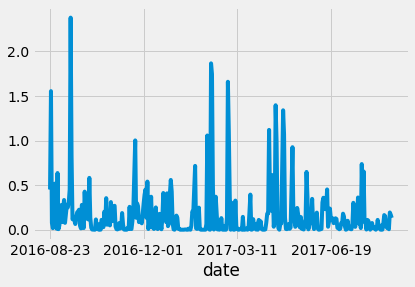

In [132]:
avg_df.plot()

In [125]:
elim_df = df_all.dropna()
elim_df.count()

id         2021
station    2021
date       2021
prcp       2021
tobs       2021
dtype: int64

In [119]:


# Find the date of the last day recorded in the data
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#Convert last day to an object so I can find a year previous
ld_object = datetime.strptime(last_day[0], '%Y-%m-%d')

x_tck = ['2016-08-23','2016-09-23','2016-10-23','2016-11-23','2016-12-23','2017-01-23','2017-02-23','2017-03-23',
         '2017-04-23','2017-05-23','2017-06-23','2017-07-23','2017-08-23']
# Calculate the date 1 year ago from the last data point in the database
year_ago = ld_object-dt.timedelta(days = 366)

# Perform a query to retrieve the data and precipitation scores for the past year
full_year = session.query(Measurement.date,Measurement.prcp).filter(func.strftime("%Y-%m-%d",Measurement.date) >= year_ago ).all()

# Save the query results as a Pandas DataFrame 
df = pd.DataFrame(full_year, columns = ['date','prcp'])
# Sort the dataframe by date
df=df.sort_values('date')
#set the index to the date column
date_index_df = df.set_index('date')


In [123]:
date_index_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<function matplotlib.pyplot.show(*args, **kw)>

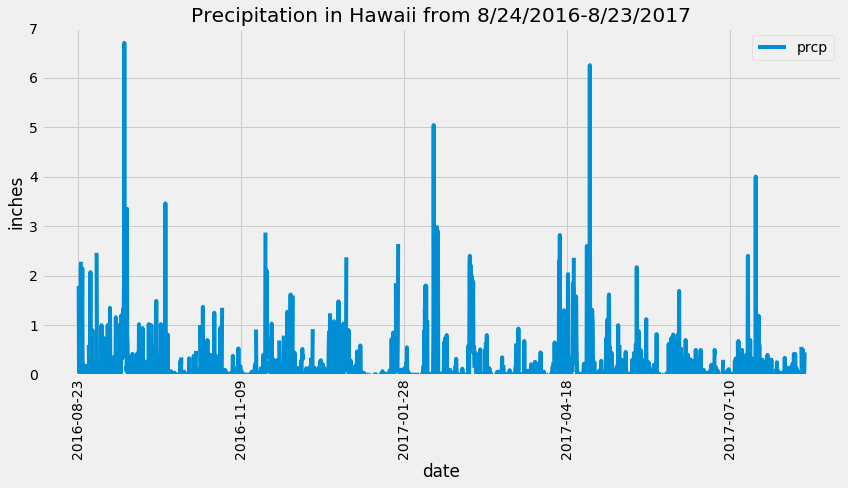

In [171]:
# Use Pandas Plotting with Matplotlib to plot the data
date_index_df.plot(title = "Precipitation in Hawaii from 8/24/2016-8/23/2017",
                   figsize = (12,7),
                   ylim =[0,7], yticks= [i for i in range(8)],
                   
                   #xticks = x_tck,
                   rot = 90)
plt.ylabel("inches")
plt.tight_layout()
plt.show

In [133]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_index_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [153]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station).distinct(Station.station).group_by(Station.station).count()
num_of_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

In [156]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station = 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [158]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs).filter_by(station= 'USC00519281').filter(func.strftime("%Y-%m-%d",Measurement.date) >= year_ago).all()

[59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83]


Text(0.5, 1.0, 'Temperature Distribution')

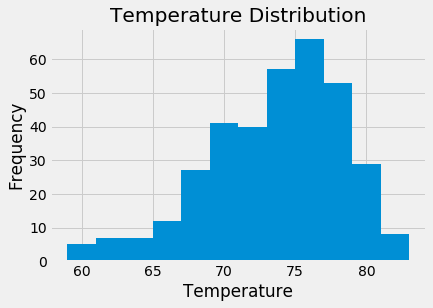

In [173]:
tobs_df = pd.DataFrame(tobs)
bins = [(59+2*i) for i in range(13)]
print(bins)
tobs_df.sort_values('tobs')
tobs_df.hist(bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Temperature Distribution")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
